In [2]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, TransitionMatrixGHMM, ZeroOneR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs

import numpy as np
import torch
import plotly.express as px
import pathlib

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

In [3]:
from scipy import linalg

rr = ZeroOneR()
T = rr.transition_matrix
T = T.sum(axis=0)

# eigenvalues/eigenvectors
Rval, Rvec = linalg.eig(T)
Lval, Lvec = linalg.eig(T.T)

# get the vecs with eigenvalue 1
Rvec = Rvec[:, np.isclose(Rval, 1)]
Lvec = Lvec[:, np.isclose(Lval, 1)].T

Lvec = Lvec/Lvec.sum()

# check that these are actually eigenvectors
assert np.allclose(Lvec @ T, Lvec)
assert np.allclose(T @ Rvec, Rvec)

inner_product = Lvec.real @ Rvec.real
print('inner_product', inner_product)
print('Lvec', np.array2string(Lvec, precision=2, suppress_small=True))
print('Rvec', np.array2string(Rvec.T, precision=2, suppress_small=True))
print('Lvec / inner_product', np.array2string(Lvec / inner_product, precision=2, suppress_small=True))
print('Lvec sum to 1', np.array2string(Lvec.real / Lvec.real.sum(), precision=2, suppress_small=True))

inner_product [[-0.57735027]]
Lvec [[0.33-0.j 0.33-0.j 0.33-0.j]]
Rvec [[-0.58+0.j -0.58+0.j -0.58+0.j]]
Lvec / inner_product [[-0.58-0.j -0.58-0.j -0.58-0.j]]
Lvec sum to 1 [[0.33 0.33 0.33]]


In [4]:
(Lvec @ np.identity(3) @ Rvec)

array([[-0.57735027+0.j]])

In [29]:
rr = ZeroOneR()
T = rr.transition_matrix
rr = TransitionMatrixGHMM(T)

pi = rr.steady_state_vector
ones = rr.right_eigenvector
emission_probs = (pi @ rr.transition_matrices @ ones) / (pi @ ones)
emission_probs.squeeze()

emission, next_latent = rr._sample_emission_and_next_latent(latent_state=np.array([[1, 0, 0]]))
print(emission)
print(next_latent)

list(rr.yield_emissions(10))

0
[[0. 1. 0.]]


[0, 1, 0, 0, 1, 0, 0, 1, 0, 0]

In [30]:
def create_fanizza_transition_matrix(alpha: float, lamb: float) -> np.ndarray:
    # Calculate intermediate values
    a_la = (1 - lamb * np.cos(alpha) + lamb * np.sin(alpha)) / (1 - 2 * lamb * np.cos(alpha) + lamb**2)
    b_la = (1 - lamb * np.cos(alpha) - lamb * np.sin(alpha)) / (1 - 2 * lamb * np.cos(alpha) + lamb**2)

    # Define tau
    tau = np.ones(4)

    # Define the reset distribution pi0
    pi0 = np.array([1 - (2 / (1 - lamb) - a_la - b_la) / 4, 1 / (2 * (1 - lamb)), -a_la / 4, -b_la / 4])

    # Define w
    w = np.array([1, 1 - lamb, 1 + lamb * (np.sin(alpha) - np.cos(alpha)), 1 - lamb * (np.sin(alpha) + np.cos(alpha))])

    # Create Da
    Da = np.outer(w, pi0)

    # Create Db (with the sine sign error fixed)
    Db = lamb * np.array([
        [0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, np.cos(alpha), -np.sin(alpha)],
        [0, 0, np.sin(alpha), np.cos(alpha)]
    ])

    # Create the transition matrix T
    T = np.zeros((2, 4, 4))
    T[0] = Da
    T[1] = Db

    # Verify that T @ tau = tau (stochasticity condition)
    assert np.allclose(T[0] @ tau + T[1] @ tau, tau), "Stochasticity condition not met"

    return T

In [31]:
T = create_fanizza_transition_matrix(alpha=2000., lamb=.49)
F_presentation = TransitionMatrixGHMM(T)
F_presentation.name = "Fanizza"

In [40]:
list(F_presentation.yield_emissions(20))


[0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0]

In [6]:
MSP = F_presentation.derive_mixed_state_presentation(depth=10)

(2047, 4)


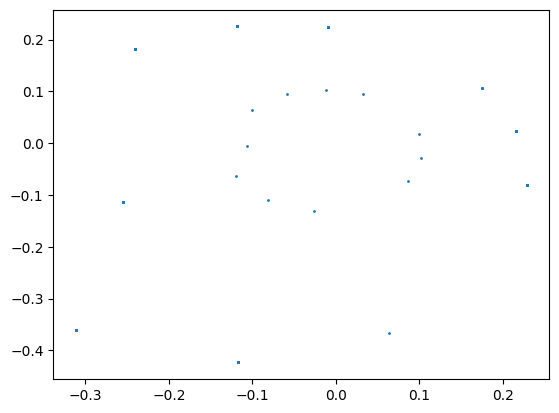

In [7]:
beliefs = np.array(MSP.belief_states).squeeze()
print(beliefs.shape)
from matplotlib import pyplot as plt
plt.scatter(beliefs[:, 2], beliefs[:, 3], alpha=1, s=1)


In [8]:
T = F_presentation.transition_matrix
T = T.sum(axis=0)
Rval, Rvec = np.linalg.eig(T)
Lval, Lvec = np.linalg.eig(T.T)
right_eigenvector = Rvec[:, np.isclose(Rval, 1)]
left_eigenvector = Lvec[:, np.isclose(Lval, 1)].T
left_eigenvector = left_eigenvector/left_eigenvector.sum()
inner_product = left_eigenvector @ right_eigenvector
print('inner_product', inner_product)
print('left_eigenvector', np.array2string(left_eigenvector, precision=2, suppress_small=True))
print('right_eigenvector', np.array2string(right_eigenvector, precision=2, suppress_small=True))
print('left_eigenvector / inner_product', np.array2string(left_eigenvector / inner_product, precision=2, suppress_small=True))
print('left_eigenvector sum to 1', np.array2string(left_eigenvector / left_eigenvector.sum(), precision=2, suppress_small=True))


inner_product [[0.5+0.j]]
left_eigenvector [[ 0.19+0.j  0.92+0.j -0.11+0.j -0.01+0.j]]
right_eigenvector [[0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]
 [0.5+0.j]]
left_eigenvector / inner_product [[ 0.37+0.j  1.85+0.j -0.21+0.j -0.01+0.j]]
left_eigenvector sum to 1 [[ 0.19+0.j  0.92+0.j -0.11+0.j -0.01+0.j]]


In [1]:
pi = F_presentation.steady_state_vector
ones = F_presentation.right_eigenvector
print(pi.shape)
print(ones.shape)
print(F_presentation.transition_matrices[0].shape)
depth = 10
for i in range(depth):
    for emission in range(F_presentation.vocab_len):
        next_process_state = (pi @ F_presentation.transition_matrices[emission]) / (pi @ ones)
        print(next_process_state)

NameError: name 'F_presentation' is not defined

In [10]:
N = 5  # You can adjust this value as needed

T_N = np.linalg.matrix_power(T, N)
(left_eigenvector @ T_N @ right_eigenvector)/(left_eigenvector @ right_eigenvector)

array([[1.+0.j]])

In [11]:
MSP = F_presentation.derive_mixed_state_presentation(depth=10)

In [12]:
import plotly.graph_objects as go

bs = np.array(MSP.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs[:, 0],
    y=bs[:, 1],
    z=bs[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    title='3D Scatter Plot of Belief States'
)

fig.show()

In [13]:
# Tom's process
import numpy as np

def create_tom_transition_matrices():
    alpha = 1.
    beta = np.sqrt(51)
    s=4*alpha**2+4*beta**2;
    alpha=alpha/s**0.5;
    beta=beta/s**0.5;

    # Assert that alpha^2 + beta^2 = 1/4
    assert np.isclose(alpha**2 + beta**2, 1/4), f"alpha^2 + beta^2 should equal 1/4, but got {alpha**2 + beta**2}"

    K0 = np.array([[alpha+beta, 0], [0, alpha-beta]])
    K1 = np.array([[alpha-beta, 0], [0, alpha+beta]])
    K2 = np.array([[alpha, beta], [beta, alpha]])
    K3 = np.array([[alpha, -beta], [-beta, alpha]])

    # Stack the matrices into a 3D array
    T = np.stack([np.kron(K0, K0),
                  np.kron(K1, K1),
                  np.kron(K2, K2),
                  np.kron(K3, K3)], axis=0)

    return T

# Create Tom's transition matrices
T_tom = create_tom_transition_matrices()
print(T_tom.sum(axis=0).sum(axis=1))
# Create a GHMM object for Tom's process
tom_presentation = TransitionMatrixGHMM(T_tom)
tom_presentation.name = "Tom's Process"
import plotly.graph_objects as go

MSP_tom = tom_presentation.derive_mixed_state_presentation(depth=8)
bs_tom = np.array(MSP_tom.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs_tom[:, 1],
    y=bs_tom[:, 2],
    z=bs_tom[:, 0],
    mode='markers',
    marker=dict(
        size=1,
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title="Tom's Process Mixed State Presentation",
    width=800,
    height=600
)

fig.show()



[1.         0.01923077 0.01923077 1.        ]


In [14]:
T_tom.shape

(4, 4, 4)

In [18]:
rr = RRXOR()
T_rr = rr.transition_matrix

rr_GHMM = TransitionMatrixGHMM(T_rr)
rr_GHMM.name = "RR"
MSP_rr = rr_GHMM.derive_mixed_state_presentation(depth=8)
bs_rr = np.array(MSP_rr.belief_states).squeeze()

fig = go.Figure(data=[go.Scatter3d(
    x=bs_rr[:, 1],
    y=bs_rr[:, 2],
    z=bs_rr[:, 0],
    mode='markers',
    marker=dict(
        size=2,
        opacity=1
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        zaxis_title='Dimension 3'
    ),
    title="RR XOR Mixed State Presentation",
    width=800,
    height=600
)

fig.show()


In [19]:
np.unique(bs_rr, axis=0).shape

(82, 5)

In [20]:
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Round the belief states to 5 decimal places and remove duplicates
unique_bs_rr = np.unique(np.round(bs_rr, decimals=5), axis=0)

# Perform PCA to reduce dimensionality to 3
pca = PCA(n_components=3)
bs_rr_pca = pca.fit_transform(unique_bs_rr)

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=bs_rr_pca[:, 0],
    y=bs_rr_pca[:, 1],
    z=bs_rr_pca[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.8,
        color=bs_rr_pca[:, 2],  # Color by the third principal component
        colorscale='Viridis',
        colorbar=dict(title="PC3")
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    title="RR XOR Mixed State Presentation (PCA 3D projection)",
    width=800,
    height=600
)

fig.show()

print(f"Original shape: {bs_rr.shape}")
print(f"Unique points shape: {unique_bs_rr.shape}")
print(f"PCA transformed shape: {bs_rr_pca.shape}")

Original shape: (351, 5)
Unique points shape: (36, 5)
PCA transformed shape: (36, 3)


2.237136465324385